# Modeling Extremes - Scipy

In this example, we will look at how we can use the `scipy` library to learn relevan distributions for extreme values, i.e., GEVD.

In [1]:
import autoroot
import pandas as pd
from scipy.stats import rv_histogram
import numpy as np
import xarray as xr
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

In [2]:
from bayesevt._src.data.local import DATASET_SPAIN_ANOMALIES

ds = xr.open_mfdataset(DATASET_SPAIN_ANOMALIES["t2max"])

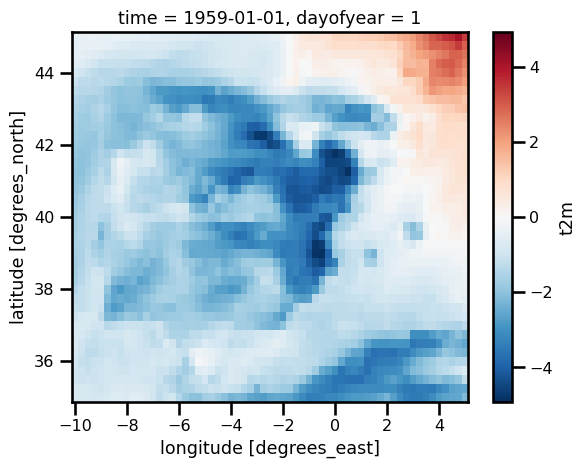

In [3]:
ds.t2m.isel(time=0).plot.pcolormesh()

In [9]:
ds.t2m.latitude.min(), ds.t2m.latitude.max()

(<xarray.DataArray 'latitude' ()> Size: 8B
 array(35.),
 <xarray.DataArray 'latitude' ()> Size: 8B
 array(45.))

## Masking

In [8]:
from bayesevt._src.geoprocessing.masks import add_country_mask, add_land_mask


In [9]:
ds = add_country_mask(ds, country="Spain")
ds = add_land_mask(ds)

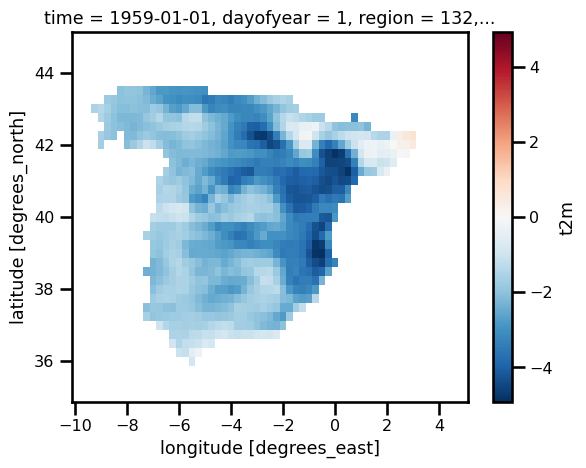

In [10]:

ds.where(ds.spain_mask==1).isel(time=0).t2m.plot()

## Clean Data

* Take Weighted Mean
* Convert Kelvin to Celsius
* Convert to DataFrame & Series
* Drop NANS
* Sort according to time
* Small Correction to Date

In [11]:
ds.longitude

<xarray.DataArray 'longitude' (longitude: 61)> Size: 244B
array([-10.  ,  -9.75,  -9.5 ,  -9.25,  -9.  ,  -8.75,  -8.5 ,  -8.25,  -8.  ,
        -7.75,  -7.5 ,  -7.25,  -7.  ,  -6.75,  -6.5 ,  -6.25,  -6.  ,  -5.75,
        -5.5 ,  -5.25,  -5.  ,  -4.75,  -4.5 ,  -4.25,  -4.  ,  -3.75,  -3.5 ,
        -3.25,  -3.  ,  -2.75,  -2.5 ,  -2.25,  -2.  ,  -1.75,  -1.5 ,  -1.25,
        -1.  ,  -0.75,  -0.5 ,  -0.25,   0.  ,   0.25,   0.5 ,   0.75,   1.  ,
         1.25,   1.5 ,   1.75,   2.  ,   2.25,   2.5 ,   2.75,   3.  ,   3.25,
         3.5 ,   3.75,   4.  ,   4.25,   4.5 ,   4.75,   5.  ], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 244B -10.0 -9.75 -9.5 -9.25 ... 4.5 4.75 5.0
Attributes:
    units:      degrees_east
    long_name:  longitude

In [11]:
# # take weighted spatial mean
# import numpy as np
# weights = spain_mask.squeeze() * np.cos(np.deg2rad(ds.latitude))
# ds = xr.open_mfdataset(data_url)
# data = ds.weighted(weights).mean(dim=["latitude", "longitude"]) - 272.15

### Region Selection

We are going to select Spain but also perhaps Madrid.

In [12]:
# # take weighted spatial mean
# weights = ds["spain_mask"] * np.cos(np.deg2rad(ds.latitude))
# data = ds.weighted(weights).mean(dim=["latitude", "longitude"])

# select MADRID region
data = ds.sel(longitude=-3.703790, latitude=40.416775, method="nearest")

In [13]:

# # convert Kelvin to Celcius
# data -= 272.15
# convert to dataframe
data = data.t2m.to_dataframe()
# create time series
data = pd.Series(data["t2m"])
# remove nans
data = data.dropna()
# sort ascending
data = data.sort_index(ascending=True)
# # start time
t0 = data.index[0]
# # rescale time
data = data - (data.index.array - pd.to_datetime(t0.year)) / pd.to_timedelta("365.2425D") * 2.87e-3
data.describe()

count    23011.000000
mean        -0.382247
std          3.740105
min        -16.210242
25%         -2.915719
50%         -0.283981
75%          2.215052
max         12.947272
Name: t2m, dtype: float64

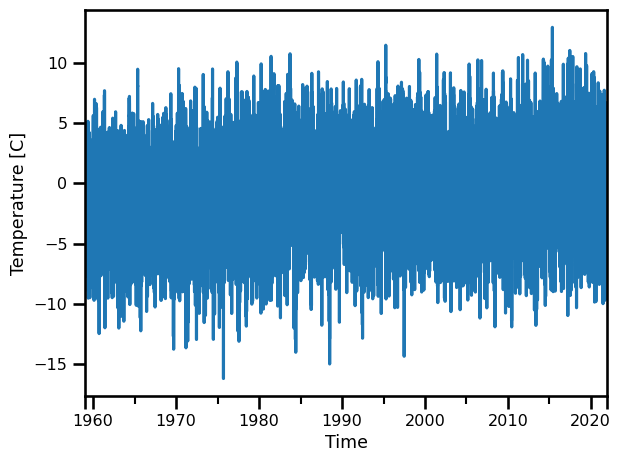

In [14]:
fig, ax = plt.subplots()

data.plot(ax=ax)

ax.set(
    xlabel="Time",
    ylabel="Temperature [C]"
)
plt.tight_layout()
plt.show()

## Extremes

In [15]:
extremes_method = "BM"
block_size = "365.2425D"
extremes_type = "high"
extremes = get_extremes(
    data, 
    method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

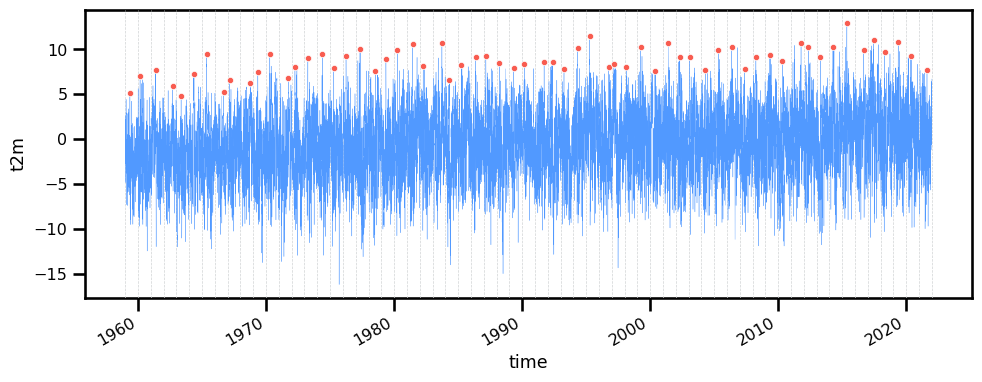

In [16]:
fig, ax = plt.subplots(figsize=(10,4))

plot_extremes(
    ax=ax,
    ts=data,
    extremes=extremes,
    extremes_method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

plt.tight_layout()
plt.show()

## Model

We will use the GEVD as our model.
The `scipy.stats` library has a `genextreme` distribution which has all of the functionality we need.
It also has built-in method to learn the parameters using the MLE method.

**Resources**:
* Scipy GEV - [scipy docs]()
* Return Values from GEV - [StackOverFlow](https://stackoverflow.com/questions/71202562/calculating-return-value-using-generalised-extreme-value-distribution-gev)

In [17]:
# fit parameters to data
params = genextreme.fit(extremes, method="MLE")
model = genextreme(*params)
print("Parameters (MLE):")
print(f"Shape - ξ: {params[0]:.4f}")
print(f"Loc   - μ: {params[1]:.4f}")
print(f"Scale - σ: {params[2]:.4f}")

Parameters (MLE):
Shape - ξ: 0.2837
Loc   - μ: 8.1587
Scale - σ: 1.6199


## Diagnostics: Goodness of Fit

**Null Hypothesis**: *The distribution of the independent samples is identical to the specified cumulative distribution*.

If the statistic is small or the p-value is high, then we accept the null hypothesis.

In [18]:
from scipy.stats import kstest

In [19]:
out = kstest(extremes, model.cdf)
print(f"Kolmogorov-Smirnov Test")
print(f"Statistic: {out.statistic:.4f}")
print(f"P-Value: {out.pvalue:.4f}")

Kolmogorov-Smirnov Test
Statistic: 0.0784
P-Value: 0.8051


We **accept** the null hypothesis.

### Viz I: CDF

In [20]:
# create a length of the domain
x_domain = np.linspace(extremes.min(), extremes.max(), 100)
# get the PDF of the distribution
y_pdf = genextreme.pdf(x_domain, *params)

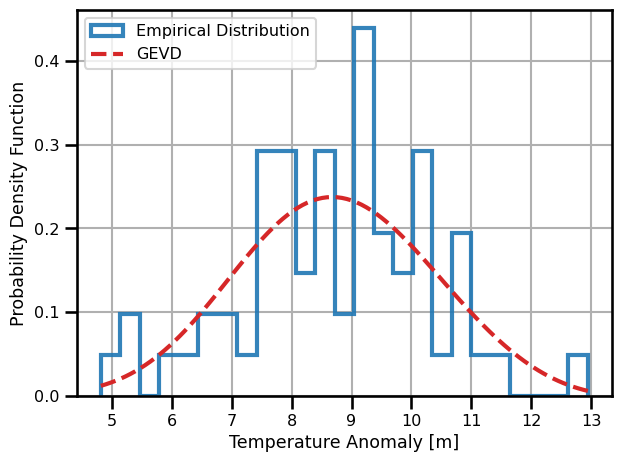

In [22]:
fig, ax = plt.subplots()

ax.hist(extremes, bins=25, rwidth=2, alpha=0.9, cumulative=False, density=True, color="tab:blue", linewidth=3, histtype="step", label="Empirical Distribution")
ax.plot(x_domain, y_pdf, linewidth=3, linestyle="--", color="tab:red", label="GEVD")

ax.set(
    xlabel="Temperature Anomaly [m]",
    ylabel="Probability Density Function",
)

plt.grid(which="both", visible=True)
plt.tight_layout()
plt.legend()
plt.show()

### Viz II: PDF

In [23]:
# get the CDF of the distribution
y_cdf = genextreme.cdf(x_domain, *params)

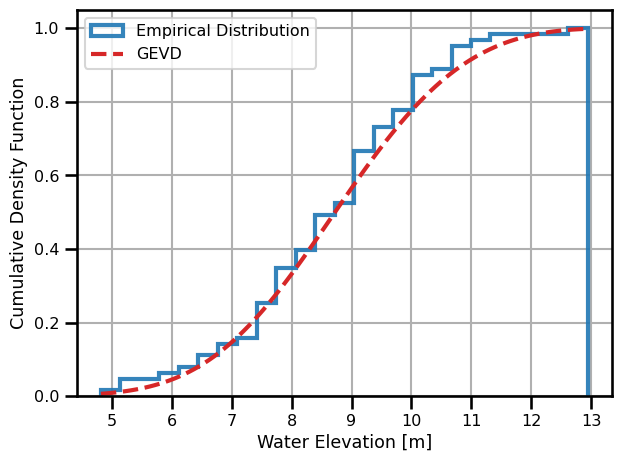

In [24]:
fig, ax = plt.subplots()

ax.hist(extremes, bins=25, rwidth=2, alpha=0.9, cumulative=True, density=True, color="tab:blue", linewidth=3, histtype="step", label="Empirical Distribution")
ax.plot(x_domain, y_cdf, linewidth=3, linestyle="--", color="tab:red", label="GEVD")

ax.set(
    xlabel="Water Elevation [m]",
    ylabel="Cumulative Density Function",
)
plt.grid(which="both", visible=True)
plt.tight_layout()
plt.legend()
plt.show()

## Return Period

A major goal of the EVT is to estimate the extreme values corresponding to some return periods.
In other words, we want to know the relationship between the non-exceedence probability and the return periods.
This relationship is given by:

$$
p(X\leq x_T) = \frac{1}{T}
$$

where $x_T$ is the extreme annual water elevation corresponding to the return period of $T$.

**Resources**:
* Return Values from GEV - [StackOverFlow](https://stackoverflow.com/questions/71202562/calculating-return-value-using-generalised-extreme-value-distribution-gev)

In [29]:
# simple return periods
return_periods = np.logspace(-0.999, 2, 100)
# calculate
return_levels = genextreme.isf(1/return_periods, *params)

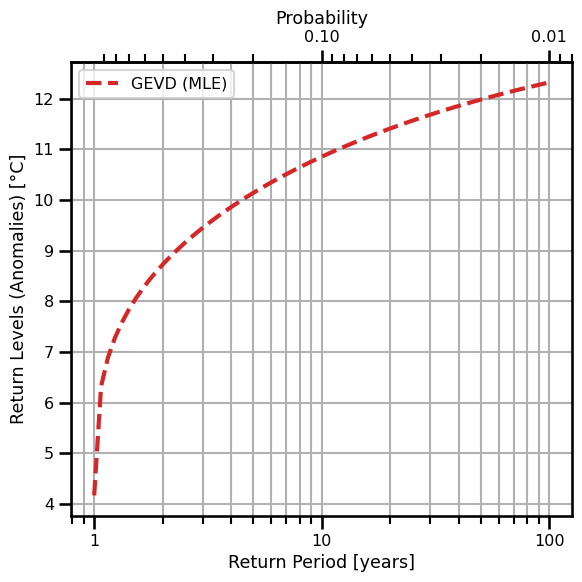

In [31]:


fig, ax = plt.subplots(figsize=(6,6))

ax.plot(
    return_periods, return_levels, 
    linestyle="--", linewidth=3, color="tab:red",
    label="GEVD (MLE)",
)


ax.set(
    xlabel="Return Period [years]",
    ylabel="Return Levels (Anomalies) [°C]",
    xscale="log",
)

# SECOND AXIS
def safe_reciprocal(x):
    """Vectorized 1/x, treating x==0 manually"""
    x = np.array(x, float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = np.inf
    x[~near_zero] = np.reciprocal(x[~near_zero])
    return x

secax = ax.secondary_xaxis("top", functions=(safe_reciprocal, safe_reciprocal))
secax.set_xlabel("Probability")
secax.set_xticks([0.1, 0.01])

# format log scale labels
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
secax.xaxis.set_major_formatter(formatter)

plt.grid(which="both", visible=True)
plt.legend()
plt.tight_layout()
plt.show()
